In [1]:
pip install datasets

In [2]:
# Cat and Dog Image Classification using TensorFlow
# Author: Huy Nguyen
# Date: 09/2024

# Importing necessary libraries
from datasets import load_dataset
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset from the Hugging Face Dataset library
ds = load_dataset("Bingsu/Cat_and_Dog")

# Display dataset information
print(ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
})


In [4]:
# Preprocess the data: resize, normalize, and convert images for model input
def preprocess_image(image, label):
    image = image.convert("RGB")  # Ensure image is in RGB mode
    image = image.resize((128, 128))  # Resize image to 128x128
    image = np.array(image) / 255.0  # Convert to numpy array and normalize to [0, 1]
    return image, label

In [5]:
# Function to create a TensorFlow dataset
def create_tf_dataset(dataset, batch_size=32):
    images = [preprocess_image(img, label)[0] for img, label in zip(dataset['image'], dataset['labels'])]
    labels = dataset['labels']

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Create a tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [6]:
# Prepare training and test sets
train_data = ds['train'].train_test_split(test_size=0.2, stratify_by_column="labels")['train']
test_data = ds['train'].train_test_split(test_size=0.2, stratify_by_column="labels")['test']

# Create datasets
train_dataset = create_tf_dataset(train_data)
test_dataset = create_tf_dataset(test_data)

In [7]:
# Define a simple model for classification
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification (cat vs dog)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Display model architecture summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.5396 - loss: 0.7060 - val_accuracy: 0.6737 - val_loss: 0.6139
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.6796 - loss: 0.6090 - val_accuracy: 0.7250 - val_loss: 0.5514
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7286 - loss: 0.5358 - val_accuracy: 0.7631 - val_loss: 0.4859
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.7764 - loss: 0.4694 - val_accuracy: 0.8238 - val_loss: 0.4064
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8121 - loss: 0.4022 - val_accuracy: 0.8294 - val_loss: 0.3722
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8475 - loss: 0.3439 - val_accuracy: 0.8512 - val_loss: 0.3392
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8794 - loss: 0.2894 - val_accuracy: 0.8494 - val_loss: 0.3438
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9002 - loss: 0.2413 - val_accu

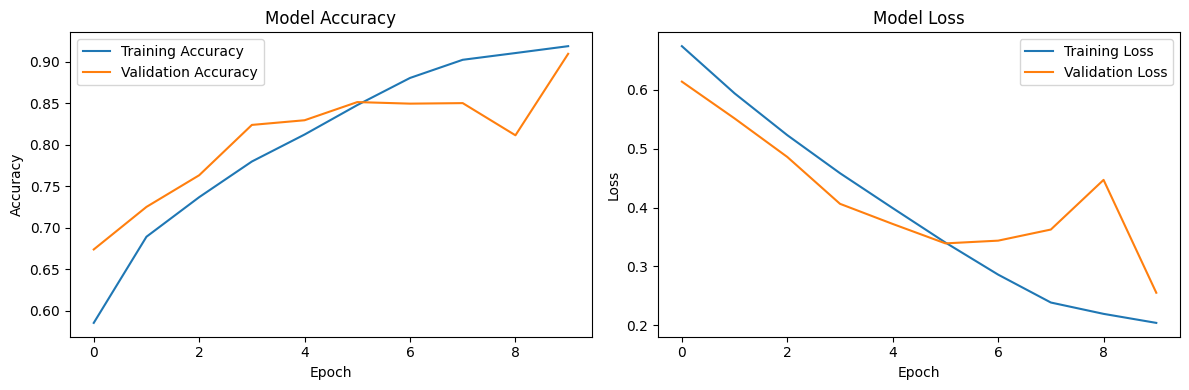

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.9109 - loss: 0.2596
Test accuracy: 0.9094


In [13]:
# Generate predictions and classification report
test_images = [preprocess_image(img, label)[0] for img, label in zip(test_data['image'], test_data['labels'])]
test_labels = test_data['labels']

predictions = model.predict(np.array(test_images))
predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]

# Generate classification report
print(classification_report(test_labels, predicted_classes, target_names=["Cat", "Dog"]))

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step
              precision    recall  f1-score   support

         Cat       0.92      0.90      0.91       800
         Dog       0.90      0.92      0.91       800

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



In [14]:
# Function to predict on a single image and classify it
def predict_image(image):
    image = image.convert("RGB")
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)[0][0]
    class_name = "Dog" if prediction > 0.5 else "Cat"
    return class_name, prediction

# Example usage
sample_image = test_data['image'][0]
class_name, confidence = predict_image(sample_image)
print(f"Predicted class: {class_name}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted class: Dog
Confidence: 0.92
